# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [2]:
using DataFrames

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time)
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Populate the population array
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
for i in 1:nchem
    for j in 1:max_t
        for k in 1:nspecies
            filtered_time_series_df = filter(row -> row[:reactor] == i && row[:time] == j && row[:variable] == string(k), time_series_df)
            if nrow(filtered_time_series_df) > 0
                pop_array[i, j, k] = filtered_time_series_df[1, :value]
            end
        end
    end
end

using Plots, FileIO

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end


display(plot_grid)

InterruptException: InterruptException:

In [2]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

Dict{Any, Any} with 501 entries:
  56.0  => [10, 23, 223, 738, 1, 1, 2, 1, 3, 1  …  11, 1, 29, 4, 12, 1, 3, 1, 1…
  35.0  => [15, 1, 110, 1, 30, 3, 1, 1, 481, 1  …  1, 1, 1, 47, 1, 152, 1, 2, 1…
  425.0 => [6, 173, 1, 1, 2, 1, 1, 70, 1, 4  …  1, 379, 1, 1, 1, 50, 1, 1, 598,…
  429.0 => [1, 149, 1, 337, 301, 7, 84, 564, 1, 1  …  75, 9, 589, 1, 130, 30, 1…
  60.0  => [1, 1, 1, 1, 1, 1, 1, 234, 4, 49  …  1, 1, 5, 7, 572, 6, 1, 3, 7, 1]
  220.0 => [7, 1, 19, 1, 752, 2, 1, 1, 1, 480  …  1, 3, 4, 411, 4, 5, 59, 1, 39…
  308.0 => [1, 1, 1, 238, 11, 5, 38, 1, 117, 1  …  10, 1, 12, 1, 38, 12, 14, 1,…
  67.0  => [1, 13, 15, 12, 86, 1, 1, 1, 1, 1  …  1, 1, 1, 8, 2, 297, 2, 1, 1, 1]
  215.0 => [1, 362, 4, 9, 66, 2, 39, 126, 1, 18  …  2, 1, 1023, 1, 3, 1, 1, 1, …
  73.0  => [80, 2, 1, 48, 5, 5, 126, 205, 2, 95  …  2, 16, 2, 1, 4, 448, 1, 3, …
  319.0 => [1, 1, 3, 30, 1, 1, 14, 201, 185, 2  …  15, 1, 2, 69, 1, 44, 48, 2, …
  251.0 => [2, 160, 1, 317, 1, 1, 67, 121, 709, 2  …  35, 91, 4, 1, 3, 19, 1,

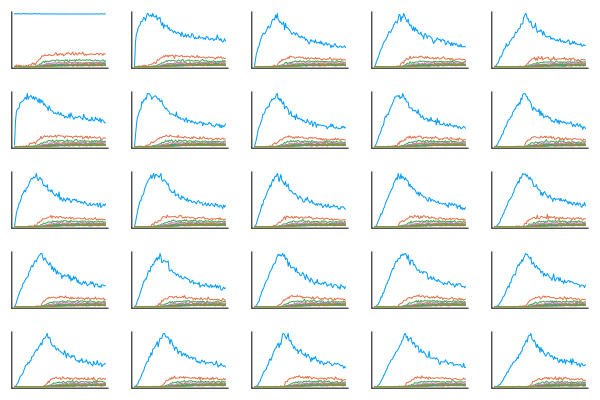

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/02_std(m)-vs-kd/L_lattice-2way-diffusion-increased-kd/plots/ts-gridplot.pdf"

In [7]:
using DataFrames, Plots, FileIO

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        # plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none, xlabel="", ylabel="", xticks=false, yticks=false)
    end
end

display(plot_grid)
savefig(plot_grid, "./plots/ts-gridplot.pdf")

# Plot the Std(M) vs $k_d$ 

## (i.e., the std of monomers vs the outflow)

In [9]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 25
nspecies = 10
t = 100

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
for i in 1:100
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = filter(row -> row[:reactor] == j, df)

            for k in 1:nspecies
                df_reactor_species = filter(row -> row[:variable] == string(k), df_reactor)
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [3]:
using DataFrames, Plots, FileIO, Statistics, FlowComplexity
using Base.Threads: @threads

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 500

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
@threads for i in 1:nsims
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = df[df.reactor .== j, :]

            for k in 1:nspecies
                df_reactor_species = df_reactor[df_reactor.variable .== string(k), :]
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [ ]:
display(pops[2,:,:])

In [10]:
stds = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        stds[i, j] = std(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(stds)

100×10 Matrix{Float64}:
 200.2    42.4     20.4      9.6      …   6.4      3.6      4.2      4.2
 200.0    42.0     15.2     13.2          5.0      3.2      4.6      4.4
 199.914  38.2     22.0     13.4          5.6      4.6      3.4      4.8
 199.984  43.8     22.2     10.0          6.2      6.4      5.4      4.4
 200.0    42.6     16.8     11.0          6.8      3.8      3.8      4.0
 200.0    36.4     17.2     10.6      …   5.8      5.2      4.2      3.4
 201.545  38.6     17.6     10.0          5.6      5.2      3.8      3.4
 200.0    38.8     18.8      9.8          4.6      5.0      5.4      4.8
 200.037  41.2     14.0     17.0          4.6      5.4      3.0      3.2
 199.867  42.4     19.0     12.2          5.2      3.8      2.6      2.8
   ⋮                                  ⋱                              
 151.382  31.1238  19.2365  13.0808       6.76585  7.50511  6.61009  4.9689
 152.676  32.4717  16.2555  13.9346       6.36867  7.20463  5.89491  5.995
 161.215  32.3355  18.730

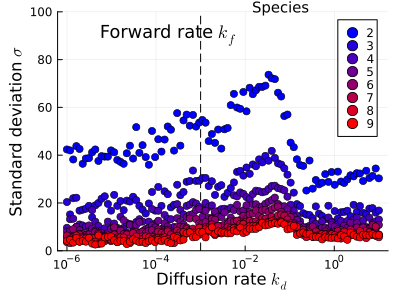

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/02_std(m)-vs-kd/L_lattice-2way-diffusion-increased-kd/plots/sd-vs-kd.pdf"

In [11]:
using LaTeXStrings

# p = plot()
title = "SD of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topright, ylim=(0,100))

n = 100
vals = exp10.(LinRange(-6,1,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(6e-6, 90, text("Forward rate " * L"k_f", :left, 12, color=:black))

annotate!(1.5e-2, 102, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, stds[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Standard deviation " * L"\sigma", label=i,
    marker_z=i, color=linear_blue_to_red, colorbar=false,)
end

# display(p)
display(s)

mkpath("./plots")
savefig("./plots/sd-vs-kd.pdf")

In [ ]:
display(stds)

In [ ]:
std([1000,10,20,50,1,0,0,0,0])

In [12]:
mu = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        mu[i, j] = mean(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(mu)

100×10 Matrix{Float64}:
  40.04    8.48   4.08   1.92   1.6    1.12   1.28   0.72   0.84   0.84
  40.0     8.4    3.04   2.64   1.64   1.16   1.0    0.64   0.92   0.88
  40.48    7.64   4.4    2.68   1.28   1.8    1.12   0.92   0.68   0.96
  40.08    8.76   4.44   2.0    2.0    1.28   1.24   1.28   1.08   0.88
  40.0     8.52   3.36   2.2    1.72   1.4    1.36   0.76   0.76   0.8
  40.0     7.28   3.44   2.12   1.36   1.4    1.16   1.04   0.84   0.68
  46.92    7.72   3.52   2.0    1.28   1.32   1.12   1.04   0.76   0.68
  40.0     7.76   3.76   1.96   2.12   1.36   0.92   1.0    1.08   0.96
  41.12    8.24   2.8    3.4    1.84   1.2    0.92   1.08   0.6    0.64
  40.72    8.48   3.8    2.44   1.68   1.56   1.04   0.76   0.52   0.56
   ⋮                                   ⋮                          
 357.88  123.88  79.28  59.24  43.92  37.68  32.12  28.08  23.12  20.24
 360.44  123.08  79.36  56.44  45.12  36.48  29.68  27.36  23.6   21.76
 346.96  118.0   73.92  59.12  44.0   39.0   2

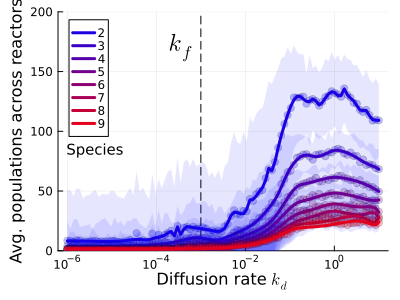

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/02_std(m)-vs-kd/L_lattice-2way-diffusion-increased-kd/plots/mu-vs-kd.pdf"

In [55]:
using LaTeXStrings, Dierckx, Polynomials, Interpolations

gr()

# p = plot()
title = "Mean of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topleft, ylim=(0,200))

n = 100
vals = exp10.(LinRange(-6,1,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(2e-4, 170, text(L"k_f", :left, 16, color=:black))

annotate!(1e-6, 85, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, mu[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Avg. populations across reactors", label=:none,
    marker_z=i, color=linear_blue_to_red, colorbar=false, alpha=0.25)

    upper_bound = mu[:, i] .+ stds[:,i]
    lower_bound = mu[:, i] .- stds[:,i]
    # linealpha à cause de l’esti de bug y save pas le pdf avec lw=0
    plot!(s, vals, upper_bound, fillrange=lower_bound, linealpha=0, fillalpha=0.1, color=linear_blue_to_red, label=:none, linewidth=0)

    x = vals
    y = mu[:, i]

    # function moving_average(data, window_size)
    #     return [mean(data[i:i+window_size-1]) for i in 1:length(data)-window_size+1]
    # end
    # window_size = 10
    # ma = moving_average(y, window_size)
    # # spline = Spline1D(x, y, k=3)  # k=3 for cubic spline
    xfine = exp10.(LinRange(-6,1,100))
    # # yfine = spline.(xfine)

    # p = fit(x, y, 10)

    # Define the smoothing parameter (0 for interpolation, higher for more smoothing)
    smoothing_param = 150.0

    # Fit a smoothed spline to the data
    spl = Spline1D(x, y, s=smoothing_param)
    
    plot!(s, xfine, spl.(xfine), linewidth=3, color=linear_blue_to_red[(i-1)/9], label=i)
end

# display(p)
display(s)

mkpath("./plots")
savefig(s, "./plots/mu-vs-kd.pdf")

In [212]:
Pkg.add("Polynomials")

   Resolving package versions...
    Updating `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Project.toml`
  [f27b6e38] + Polynomials v4.0.11
  No Changes to `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Manifest.toml`
